# Face Generation

In this project, a DCGAN will be defined and trained on a dataset of faces. The goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project is broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, there will be visualisation of the results of the trained Generator to see how it performs; the generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) data is used to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN), and so, a deeper networks needs to be defined and trained them for a longer time to get good results. GPU should be used for training.

### Pre-processed Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If working locally, this data can be downloaded [here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip).

This is a zip file that needs to be extracted in the home directory of this notebook for further loading and processing. After extracting the data, there should be a directory of data `processed_celeba_small`.

In [1]:
# Can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since faces are going to be generated, the annotations is not needed, only images are needed. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

This project's main focus is on building the GANs, so pre-processed image are used. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> A few other steps are needed to **transform** this data and create a **DataLoader**.

#### `get_dataloader` function, satisfies these requirements:

* The images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* The function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended to use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# Necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    data_transforms = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    
    dataset = datasets.ImageFolder(data_dir, transform = data_transforms)
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return data_loader

## Create a DataLoader

#### A DataLoader `celeba_train_loader` with appropriate hyperparameters.

The above function is called and a dataloader is created to view images. 
* Decide on any reasonable `batch_size` parameter
* `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 64
img_size = 32

# Call the function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

Next step is to view some images! There will be square images of somewhat-centered faces.

Note: A convertion of the Tensor images into a NumPy type is needed and transpose the dimensions to correctly display an image.

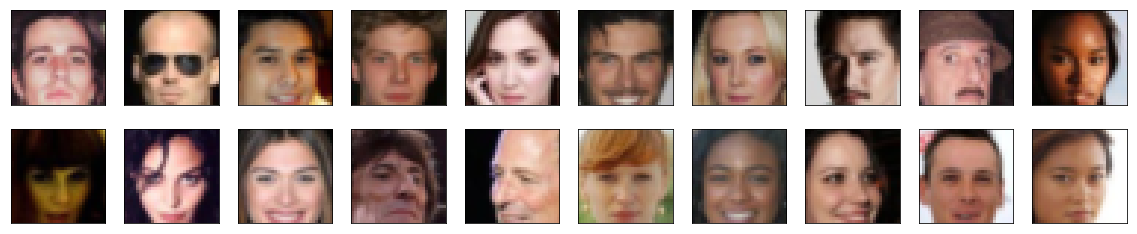

In [6]:
# Helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Pre-process the image data and scale it to a pixel range of -1 to 1

A bit of pre-processing is required; The output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, rescale the training images to a range of -1 to 1 is required. (Right now, they are in a range from 0-1.)

In [7]:
# The scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # Assume x is scaled to (0, 1)
    # Scale to feature_range and return scaled x
    
    min_range, max_range = feature_range
    x = x * (max_range-min_range) + min_range
    return x

In [8]:
# Check scaled range
# Should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8745)
Max:  tensor(0.8667)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

The first task will be to define the discriminator. This is a convolutional classifier, only without any maxpooling layers. To deal with this complex data, it's suggested to use a deep network with **normalization**. 

#### The Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def conv_layer(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    layers=[]
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        self.conv1 = conv_layer(3, conv_dim, batch_norm=False)
        self.conv2 = conv_layer(conv_dim, conv_dim*2)
        self.conv3 = conv_layer(conv_dim*2, conv_dim*4)
        self.conv4 = conv_layer(conv_dim*4, conv_dim*8)
        
        self.fc = nn.Linear(conv_dim * 32, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        x = x.view(-1, self.conv_dim*32)
        x = self.fc(x)
        
        return x

tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### The Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
def deconv_layer(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    
    layers=[]
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        
        self.deconv1 = deconv_layer(conv_dim*8, conv_dim*4)
        self.deconv2 = deconv_layer(conv_dim*4, conv_dim*2)
        self.deconv3 = deconv_layer(conv_dim*2, conv_dim)
        self.deconv4 = deconv_layer(conv_dim, 3, batch_norm=False)
        self.fc = nn.Linear(z_size, conv_dim * 32)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        x = self.fc(x)
        batch_size = x.shape[0]
        x = x.view(batch_size, self.conv_dim*8, 2, 2)
        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = self.deconv4(x)
        
        x = torch.tanh(x)
        
        return x

tests.test_generator(Generator)

Tests Passed


## Initialize the weights of the networks

To help the models converge, initialize the weights of the convolutional and linear layers in the model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, the next task will be to define a weight initialization function that does just this!

#### The weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # Classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Apply initial weights to convolutional and linear layers
    if (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

## Build complete network

Define the models' hyperparameters and instantiate the discriminator and generator from the classes defined above. 

In [15]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # Define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # Initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

#### Model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=

### Training on GPU

Check if the training can be done on the GPU. Here, it'll be set as a boolean variable `train_on_gpu` and a variable which will state whether it's `cuda` or `cpu`. Later, this will help in ensuring the following are moved to GPU, where appropriate: 
>* Models,
* Model inputs
* Loss function arguments

In [17]:
import torch

# Check for a GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train the neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* The discriminator needs to output 1 for real images and 0 for fake images, so set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Real and fake loss functions

Either use cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.

In [18]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)

    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Optimizers for the Discriminator (D) and Generator (G)

Optimizers for the models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

lr=0.0001
beta1=0.3
beta2=0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. The functions `real_loss` and `fake_loss` will be used to help calculate the discriminator losses.

* Train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

Prints out some loss statistics and save some generated "fake" samples.

#### The training function

Keep in mind that, if the models is moved to GPU, all model inputs also need to be moved to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # Move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # Keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # Move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # Epoch training loop
    for epoch in range(n_epochs):

        # Batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            # Calculating real discriminator loss
            real_images = real_images.to(device)
            
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            z = z.to(device)
            fake_images = G(z)
            
            # Calculating fake discriminator loss
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # Calculate total loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            z = z.to(device)
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images and perform backprop
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()
            
            # Print some loss stats
            if batch_i % print_every == 0:
                # Append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # Print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # This code assumes the generator is named G
        # Generate and save sample, fake images
        G.eval() # For generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # Back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # Finally return losses
    return losses

Set the number of training epochs and train the GAN!

In [21]:
# Number of epochs 
n_epochs = 10

# Call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   10] | d_loss: 1.6134 | g_loss: 1.0202
Epoch [    1/   10] | d_loss: 0.2141 | g_loss: 3.7962
Epoch [    1/   10] | d_loss: 0.0812 | g_loss: 4.7834
Epoch [    1/   10] | d_loss: 0.0301 | g_loss: 5.4743
Epoch [    1/   10] | d_loss: 0.0190 | g_loss: 5.6616
Epoch [    1/   10] | d_loss: 0.0119 | g_loss: 5.6771
Epoch [    1/   10] | d_loss: 0.0086 | g_loss: 5.8359
Epoch [    1/   10] | d_loss: 0.0097 | g_loss: 6.0434
Epoch [    1/   10] | d_loss: 0.0633 | g_loss: 4.0119
Epoch [    1/   10] | d_loss: 0.0364 | g_loss: 4.8205
Epoch [    1/   10] | d_loss: 0.1202 | g_loss: 4.8957
Epoch [    1/   10] | d_loss: 0.1717 | g_loss: 3.0454
Epoch [    1/   10] | d_loss: 0.3414 | g_loss: 3.7179
Epoch [    1/   10] | d_loss: 0.8623 | g_loss: 4.1158
Epoch [    1/   10] | d_loss: 0.1499 | g_loss: 2.3040
Epoch [    1/   10] | d_loss: 0.4162 | g_loss: 2.7828
Epoch [    1/   10] | d_loss: 0.8048 | g_loss: 4.6612
Epoch [    1/   10] | d_loss: 0.9916 | g_loss: 3.6154
Epoch [    1/   10] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

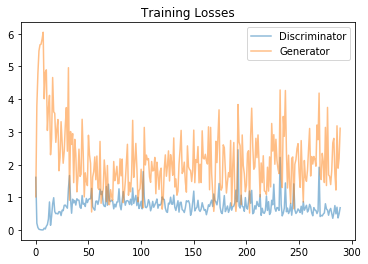

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and analyse the strengths and weaknesses of the trained models.

In [23]:
# Helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

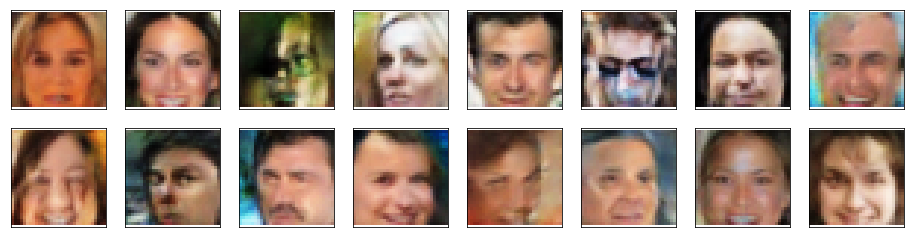

In [25]:
_ = view_samples(-1, samples)

### Analysis of the generated samples and how might the model be improved?
Consideration:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**
* There needs to be a more diverse dataset to result in output which vary. The current dataset is biased towards white celebrities therefore output produced are mostly white.
* There needs to be further training to improve the quality of the output images, but with a greater dataset. Due to the small epoch training, images currently appear pixelated or don't produce the best facial features _(such as the eye)_. However, with the current dataset, increasing the epochs would not have a significant improvement as seen by the training loss graph. 
* If image sizes are increased _(such as to 128x128 or 256x256)_, the model can be improved. Different optimizers, loss functions, hyperparameters can also improve the results.
